# Detection

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import random
import itertools

### Load data and preprocessing

In [ ]:
# Load data
def load_data(path="data/detection_"):
    """
    Load data from path, return train, val, test \n
    """
    # N_tot = total number of images in the dataset

    data_train = torch.load(path + "train.pt")
    data_val = torch.load(path + "val.pt")
    data_test = torch.load(path + "test.pt")


    return data_train, data_val, data_test



def visualize_random_images(data, num_images):
    """
    Visualizes random images from the data
    """
    indices = random.sample(range(len(data)), num_images)
    samples = [data[i] for i in indices]
    # Set up the figure
    plt.figure(figsize=(6, 4))
    
    # Loop over the selected samples
    for i, (img, label) in enumerate(samples):
        plt.subplot(1, num_images, i+1)
        
        # If the image is a tensor, convert it to a numpy array for plotting.
        if torch.is_tensor(img):
            # Convert from (C, H, W) to (H, W, C)
            img = img.permute(1, 2, 0).numpy()
            
        plt.imshow(img)
        plt.axis('off')
        plt.tight_layout()
        plt.show()


def data_distribution_detection(data):
    """
    Plots the distribution of class labels in a detection dataset.
    Assumes each label is a tensor of shape (H_out, W_out, 6), where the 6th element (index 5) is the class label.
    """
    all_labels = []
    
    for _, label in data:
        # label is a tensor of shape (H_out, W_out, 6)
        H_out, W_out, _ = label.shape
        for i in range(H_out):
            for j in range(W_out):
                # there is a number in the image
                if label[i, j, 0] == 1:
                    all_labels.append(label[i, j, 5].item())

                
    # Calculate distribution using numpy
    unique_labels, counts = np.unique(all_labels, return_counts=True)
    distribution = dict(zip(unique_labels, counts))
    
    # Convert to strings for plotting
    x_labels = [str(int(lbl)) for lbl in unique_labels]  
    
    # Visualize the label distribution using a bar chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(x_labels, counts, color='skyblue')
    
    # Add text on top of each bar to display count
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f"{count}", ha='center', va='bottom', fontsize=10)

    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Detection Data Distribution (for each grid cell)')
    plt.show()
    
    return distribution


In [3]:
data_train, data_val, data_test = load_data()

/var/folders/z4/lpyly_x97q9bvdf2n62j780h0000gn/T/ipykernel_39668/807810264.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_train = torch.load(path + "train.pt")
/va

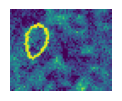

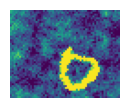

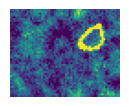

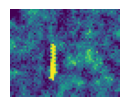

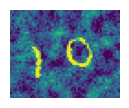

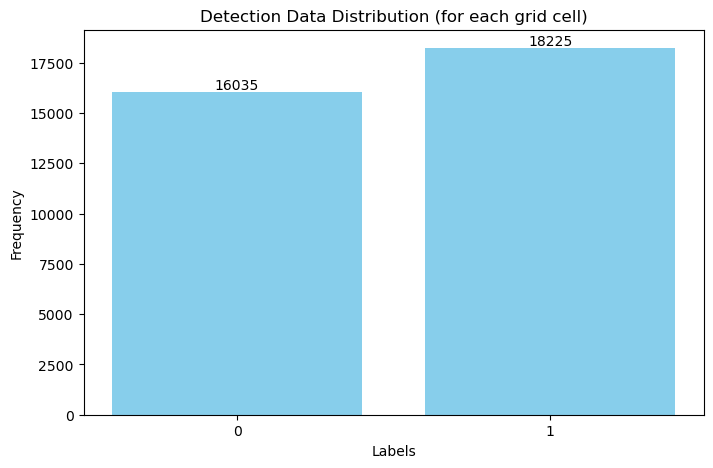

{0.0: 16035, 1.0: 18225}

In [ ]:
visualize_random_images(data_train, 5)
data_distribution_detection(data_train)

### Models

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

class model_1(nn.Module):
    # same as in localization but with only conv layers instead of fully connected at the end
    
    def __init__(self, in_channels=1, out_channels=7): #out channels: 5 + C = 7
        super().__init__()
        # H_in, W_in = 48, 60
        # shape in = torch.Size([64, 1, 48, 60])
        
        self.conv1 = nn.Conv2d(in_channels, 4, kernel_size=3, stride=1, padding=1) #size: 48x60
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1) #size: 48x60
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #size: 24x30
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1) #size: 24x30
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) #size: 24x30
        # max_pool, size: 12x15
        self.conv5 = nn.Conv2d(32, 16, kernel_size=(3,2), stride=1, padding=1) #size: 12x16
        # max_pool, size: 6x8
        self.conv6 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1) #size: 6x8
        # max_pool, size: 3x4
        self.conv7 = nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1) #size: 3x4
        
        self.conv8 = nn.Conv2d(4, out_channels, kernel_size=4, stride=1, padding=1) #size: 2x3

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv3(out)
        out = F.relu(out)
        out = self.conv4(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv5(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv6(out)
        out = F.relu(out)
        out = self.max_pool(out)
        out = self.conv7(out)
        out = F.relu(out)
        out = self.conv8(out)
        out = F.relu(out)

        # Convert from (N, C, H, W) to (N, H, W, C)
        out = out.permute(0, 2, 3, 1)

        return out

Training on device cpu.


### Model 2 - Residual network

In [ ]:
class ResidualBlock(nn.Module):
    """
    A single residual block with two Conv-BN-ReLU sequences
    and a skip connection: output = ReLU( x + F(x) ).
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResidualBlock, self).__init__()
        
        padding = 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=kernel_size, 
                               stride=stride, 
                               padding=padding, 
                               bias=False)
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, 
                               kernel_size=kernel_size, 
                               stride=1, 
                               padding=padding, 
                               bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # needed if input and output have different shapes 
        # applying a 1 x 1 convolution reshapes the input to the correct dimension
        self.shortcut = nn.Sequential()
        if (stride != 1) or (in_channels != out_channels):
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 
                          kernel_size=1, 
                          stride=stride, 
                          bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # saves original input x
        identity = x 

        # First convolution
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        # Second convolution
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Applies the shortcut if needed
        identity = self.shortcut(identity)
        
        # Add skip connection
        out += identity
        out = F.relu(out)
        
        return out

class SimpleResNet(nn.Module):
    def __init__(self, out_channels=7):
        """
        ResNet-like model that ends with a final output of dimension 7.
        """
        super().__init__()

        # Stage 1: 1 -> 4 -> 8 channels, then pool
        self.block1 = ResidualBlock(1, 4)
        self.block2 = ResidualBlock(4, 8)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 48×60 -> 24×30

        # Stage 2: 8 -> 16 -> 32, then pool
        self.block3 = ResidualBlock(8, 16)
        self.block4 = ResidualBlock(16, 32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 24×30 -> 12×15

        # Stage 3: conv (3,2) from 32 -> 16, then pool
        self.conv5 = nn.Conv2d(32, 16, kernel_size=(3,2), 
                               stride=1, padding=(1,1), 
                               bias=False) # 12x16
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 12×16 -> 6×8

        # Stage 4: 16 -> 8, then pool
        self.block5 = ResidualBlock(16, 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # 6×8 -> 3×4

        # Final block: 8 -> 4
        self.block6 = ResidualBlock(8, 4)

        # Conv layer to get correct output size
        self.conv6 = nn.Conv2d(4, out_channels, kernel_size=4, stride=1, padding=1, bias = False) # 3x4 -> 2x3


    def forward(self, x):
        # Stage 1
        out = self.block1(x)
        out = self.block2(out)
        out = self.pool1(out)

        # Stage 2
        out = self.block3(out)
        out = self.block4(out)
        out = self.pool2(out)

        # Stage 3
        out = self.conv5(out)
        out = F.relu(out)
        out = self.pool3(out)

        # Stage 4
        out = self.block5(out)
        out = self.pool4(out)

        # Final block
        out = self.block6(out) #shape : torch.Size([64, 4, 3, 4])

        # final conv layer
        out = self.conv6(out) # shape : torch.Size([64, 7, 2, 3])

        # reshape to get desired output : (N, C, H, W) to (N, H, W, C)
        out = out.permute(0, 2, 3, 1)
        return out

### Normalize Images

In [ ]:

def mean_std(data):
    """
    Calculate the mean and standard deviation of the data.
    """
    img, _ = data.tensors
    img = img.float()
    mean = img.mean(dim=(0, 2, 3))
    std = img.std(dim=(0, 2, 3))

    print(f"Mean: {mean}")
    print(f"Std: {std}")

    return mean, std


class DetectionDataset(Dataset):
    """
    A dataset class for representing the data and for applying normalization
    """
    def __init__(self, data, preprocessor=None):
        self.data = data
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        
        if self.preprocessor:
            image = self.preprocessor(image)
            
        return image, label


In [ ]:
# calculate the mean and std, and create preprocessor
mean, std = mean_std(data_train)
preprocessor = transforms.Compose([
        transforms.Normalize(mean, std)
])

# preprocess data
train_data = DetectionDataset(data_train, preprocessor = preprocessor)
val_data = DetectionDataset(data_val, preprocessor = preprocessor)
test_data = DetectionDataset(data_test, preprocessor = preprocessor)

Mean: tensor([0.2989])
Std: tensor([0.1967])


### Loss function

In [ ]:

def localization_loss(y_pred, y_true):
    """
    Calculates the detection loss, localization loss and classification loss.
    Returns a total loss

    y_pred = [p, x, y, w, h, c_1, c_2]
    y_true = [p, x, y, w, h, c]
    """
    # Detection loss
    L_A = nn.BCEWithLogitsLoss()
    # Bounding box loss (localization loss)
    L_B = nn.MSELoss()
    # Classification loss
    L_C = nn.CrossEntropyLoss()

    # Convert y_true from [p, x, y, w, h, c] to [p, x, y, w, h, c_1, c_2]
    c = y_true[5].long()  # Extract the class index
    y_true_one_hot = torch.zeros(2, device=y_true.device)  # Create a zero tensor for one-hot encoding
    y_true_one_hot.scatter_(0, c.unsqueeze(0), 1)  # Set the corresponding class index to 1
    y_true = torch.cat([y_true[:5], y_true_one_hot], dim=0)  # Concatenate the one-hot encoded classes with the rest of y_true

        
    return torch.where(
        # if there is an object; calculate input
        condition=y_true[0].bool(), 

        # L = L_A + L_B + L_C, when object is detected
        input = L_A(y_pred[0], y_true[0]) + 
                L_B(y_pred[1:5], y_true[1:5]).sum() + 
                L_C(y_pred[5:], y_true[5:]), 

        # L = L_A, when object is not detected
        other = L_A(y_pred[0], y_true[0])
    )


def detection_loss(y_pred, y_true):
    """
    Calculates localization loss for each image and each grid cell, returns average loss
    """
    # y_pred.shape = torch.Size([64, 2, 3, 7])
    # y_true.shape = torch.Size([64, 2, 3, 6])
    
    imgs = y_true.shape[0]
    H = y_true.shape[1]
    W = y_true.shape[2]

    d_loss = 0

    # calculate localization loss for each image, and each grid cell
    for img in range(imgs):
        for h in range(H):
            for w in range(W):
                y_true_gc = y_true[img][h][w]
                y_pred_gc = y_pred[img][h][w]
                d_loss += localization_loss(y_pred_gc, y_true_gc)
            
    # return average loss
    return d_loss / (imgs * H * W)


### Accuracy, IoU, Overall Performance

In [ ]:
def convert_box_local_to_global(box, i, j, cell_h, cell_w):
    """
    Convert a bounding box from local cell coordinates to global image coordinates.
    The box is given in center format: [x, y, w, h] relative to the cell (values in [0,1]).
    i, j are the row and column indices of the cell.
    Return box in corner format
    """
    x, y, w, h = box  

    # Compute global center
    global_x_center = j * cell_w + x * cell_w
    global_y_center = i * cell_h + y * cell_h

    # Compute global width and height
    global_w = w * cell_w
    global_h = h * cell_h

    # Convert to corner format: [x_min, y_min, x_max, y_max]
    x_min = global_x_center - global_w / 2
    y_min = global_y_center - global_h / 2
    x_max = global_x_center + global_w / 2
    y_max = global_y_center + global_h / 2

    # returns box in corner format
    return torch.tensor([x_min, y_min, x_max, y_max], device=box.device)

In [ ]:
def intersection(b1, b2):
    """
    Compute intersection between 2 bb on format [x1, y1, x2, y2]
    """
    
    xA = max(b1[0], b2[0]) # find largest x value for topleft corner
    yA = max(b1[1], b2[1]) # find largest y value for topleft corner
    # (xA, yA) is topleft of intersection 
    
    xB = min(b1[2], b2[2]) # find smallest x value for downright corner
    yB = min(b1[3], b2[3]) # find smallest y value for downright corner
    # (xB, yB) is downright of intersection 

    # calculate area of intersection box
    area = max(xB-xA, 0) * max(yB-yA, 0)
    return area

   
def IoU(bb1, bb2):
    """
    Compute IoU given 2 bb in corner format (global) [x_min, y_min, x_max, y_max]
    """

    # calculate intersection of the boxes
    intersect = intersection(bb1, bb2)

    # Compute width and height from corner format
    w1, h1 = bb1[2] - bb1[0], bb1[3] - bb1[1]
    w2, h2 = bb2[2] - bb2[0], bb2[3] - bb2[1]

    # calculate union of the boxes
    union = w1 * h1 + w2 * h2 - intersect

    IoU = intersect / union if union > 0 else 0
    return IoU


In [ ]:
def compute_IoU_detection(model, loader, preprocessor=None):
    """
    Compute IoU performance of the model on the given dataset
    """
    model.eval()
    iou = []

    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            
            images = images.to(device) # shape : torch.Size([64, 1, 48, 60])
            labels = labels.to(device) # shape : torch.Size([64, 2, 3, 6])

            outputs = model(images) # shape : torch.Size([64, 2, 3, 7])

            # Determine grid dimensions
            _, H_out, W_out, _ = outputs.shape
            cell_h = 48 / H_out
            cell_w = 60 / W_out

            # go over each image
            for img in range(len(labels)): 
                # loop over grid cells, assume only one number per grid cell
                for i in range(H_out):
                    for j in range(W_out):
                        # if there is a object in the grid cell and a predicted object
                        if labels[img, i, j, 0] == 1 and torch.sigmoid(outputs[img, i, j, 0]) > 0.5:
                            # find the box coordinates
                            t_box = labels[img, i, j, 1:5]
                            p_box = outputs[img, i, j, 1:5]

                            # convert coordinates from local to global before calculating IoU
                            t_box = convert_box_local_to_global(t_box, i, j, cell_h, cell_w)
                            p_box = convert_box_local_to_global(p_box, i, j, cell_h, cell_w)

                            # calculate iou and store
                            iou.append(IoU(p_box, t_box))

                        # if there is an object in the grid cell but not a predicted object, iou = 0
                        elif labels[img, i, j, 0] == 1:
                            iou.append(0)

    # return average IoU
    return sum(iou) / len(iou) if len(iou) > 0 else 0


def compute_accuracy_detection(model, loader, preprocessor=None):
    """
    Compute accuracy performance of the model on the given dataset
    """

    model.eval()
    num_correct = 0
    num_samples = 0
        
    with torch.no_grad():
        for images, labels in loader:
            if preprocessor:
                images = preprocessor(images)
            
            images = images.to(device) # shape : torch.Size([64, 1, 48, 60])
            labels = labels.to(device) # shape : torch.Size([64, 2, 3, 6])

            outputs = model(images) # shape : torch.Size([64, 2, 3, 7])

            mask = (labels[:, :, :, 0] == 1)  # Check for objects in the grid

            if mask.sum() == 0:
                continue

            # change output to probabilities
            class_probs = torch.softmax(outputs[mask][:, 5:], dim=1)
            
            # find the predicted class
            class_pred = torch.argmax(class_probs, dim=1)

            class_true = labels[mask][:, 5]

            # store number of correct predictions and total number of samples
            num_correct += (class_pred == class_true).sum().item()
            num_samples += mask.sum().item()
    
    return num_correct/num_samples if num_samples > 0 else 0

In [ ]:
def overall_performance(model, loader, preprocessor=None):
    """
    Compute the overall performance of the model on the given dataset
    """
    
    # calculate accuracy and iou
    accuracy = compute_accuracy_detection(model, loader, preprocessor)
    IoU = compute_IoU_detection(model, loader, preprocessor)

    # calculate overall performance
    performance = (accuracy + IoU) / 2
    
    return performance, accuracy, IoU

### Training

In [ ]:

def train(n_epochs, optimizer, model, loss_func, train_loader):
    """
    Trains the given model for n_epochs using the given optimizer, loss function and dataloader
    """

    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    # store for plotting
    accuracies = []
    ious = []
    performances = []
    
    for epoch in range(1, n_epochs + 1):
        # put model in train mode again since overall_performance puts the model in eval mode
        model.train()

        # store the loss for each epoch
        loss_train = 0.0
        
        for imgs, labels in train_loader:

            imgs = imgs.to(device=device) # shape = torch.Size([64, 1, 48, 60])
            labels = labels.to(device=device) # shape = torch.Size([64, 2, 3, 6])

            outputs = model(imgs) # shape = torch.Size([64, 2, 3, 7])
            
            loss = loss_func(outputs, labels) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch)

        # calculate performance, accuracy and IoU after the epoch and store them
        p, a, i = overall_performance(model, train_loader, preprocessor=None)
        accuracies.append(a)
        ious.append(i)
        performances.append(p)
        
        print('{}  |  Epoch {}  |  Training loss {:.5f}  |  Accuracy {:.5f}  | IoU {:.5f}  |  Overall {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch, a, i, p))
        
    return losses_train, performances, accuracies, ious
    


### Prediction

In [17]:
def unnormalize(image, mean, std):
    mean = torch.tensor(mean, device=image.device).view(-1, 1, 1)
    std = torch.tensor(std, device=image.device).view(-1, 1, 1)
    return image * std + mean


def visualize_predictions_detection(model, image, label, preprocessor=None, mean=[0.0], std=[1.0], detection_threshold=0.5):
    """
    Visualizes detection predictions.
    
    Assumptions:
      - The model outputs a tensor of shape (N, H_out, W_out, C+5) for a single image.
      - For each grid cell, the channels represent:
          channel 0: predicted objectness (pc)
          channels 1:4: predicted bounding box (x, y, w, h) in local (cell) coordinates
          channels 5: end: predicted class scores (we take argmax)
      - The ground truth label for the image is a tensor of shape (H_out, W_out, 6) with the same format.
    """

    model.eval()
    device = next(model.parameters()).device

    # Preprocess image if needed
    image_proc = preprocessor(image) if preprocessor else image.clone()
    image_proc = image_proc.unsqueeze(0).to(device) #, dtype=torch.double)
    
    with torch.no_grad():
        outputs = model(image_proc)  # shape: (1, H_out, W_out, C+5)

    # Remove batch dimension
    outputs = outputs[0] # shape : [2, 3, 7]
    
    # Assume ground truth label is already in shape (H_out, W_out, 6)
    # Unnormalize image for display
    image_disp = unnormalize(image, mean, std)
    image_disp = (image_disp.clamp(0, 1) * 255).to(torch.uint8)
    if image_disp.shape[0] == 1:
        image_disp = image_disp.repeat(3, 1, 1)
    _, H, W = image_disp.shape
    
    # Determine grid dimensions
    H_out, W_out, _ = outputs.shape
    cell_h = H / H_out
    cell_w = W / W_out

    pred_boxes = []
    pred_colors = []
    gt_boxes = []
    gt_colors = []
    
    # Loop over grid cells
    for i in range(H_out):
        for j in range(W_out):
            cell_pred = outputs[i, j]  # This is a vector of size (C+5)
            #print(cell_pred)
            pred_pc = torch.sigmoid(cell_pred[0]).item()
            # Only consider predictions with sufficient confidence
            if pred_pc > detection_threshold:
                # Get predicted box (channels 1:5) and class prediction (channels 5 and onwards)
                cell_box = cell_pred[1:5]
                global_box = convert_box_local_to_global(cell_box, i, j, cell_h, cell_w)
                pred_boxes.append(global_box)
                pred_colors.append("red")
            # For ground truth, assume label is a tensor of shape (H_out, W_out, 6)
            cell_gt = label[i, j]
            gt_pc = cell_gt[0].item()
            if gt_pc > 0.5:
                gt_box = cell_gt[1:5]
                global_gt_box = convert_box_local_to_global(gt_box, i, j, cell_h, cell_w)
                gt_boxes.append(global_gt_box)
                gt_colors.append("green")
    
    # Combine predicted and ground truth boxes for drawing
    boxes = []
    colors = []
    if pred_boxes:
        boxes.extend(pred_boxes)
        colors.extend(pred_colors)
    if gt_boxes:
        boxes.extend(gt_boxes)
        colors.extend(gt_colors)
    
    if boxes:
        boxes = torch.stack(boxes)
        image_with_boxes = draw_bounding_boxes(image_disp, boxes, colors=colors, width=1)
    else:
        image_with_boxes = image_disp

    image_np = image_with_boxes.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(5,5))
    plt.imshow(image_np)
    plt.axis("off")
    plt.title("Detection: Predictions vs Ground Truth")
    plt.show()

## Model Selection pipeline

In [19]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

loss_func = detection_loss

In [ ]:
# Pipeline for training different models and picking the best one
# based on performance on val data 

def model_selection():

    # Defining standard learning rate and weight decay for model selection
    learning_rates = [0.001]
    weight_decays = [0]

    # List of model classes to test
    models = [SimpleResNet, model_1] 

    best_model = None
    best_score = 0
    best_hyperparams = {}

    # Loop over each model type
    for model_class in models:
        # Loop over all combinations of learning rate and weight decay
        for lr, wd in itertools.product(learning_rates, weight_decays):
            print(f"Training {model_class.__name__} with lr={lr}, weight_decay={wd}")
            # Instantiate a new model
            model = model_class()
            
            # Create an optimizer with the current hyperparameters
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            
            # Train the model
            train( 
                n_epochs=5,
                optimizer=optimizer,
                model=model,
                loss_func=loss_func,
                train_loader=train_loader)
            
            # Evaluate the model
            model.eval()
            combined_performance, accuracy, IoU = overall_performance(model, val_loader, preprocessor=None)

            print(f"Accuracy: {accuracy:.4f}")
            print(f"Iou: {IoU:.4f}")
            print(f"Combined performance: {combined_performance:.4f}\n")
            
            # Update best model and hyperparameters if performance improved
            if combined_performance > best_score:
                best_score = combined_performance
                best_model = model
                best_hyperparams = {
                    'model': model_class.__name__,
                    'lr': lr,
                    'weight_decay': wd
                }

    return best_model, best_score, best_hyperparams 

best_model, best_score, best_hyperparams = model_selection()

Training SimpleResNet with lr=0.001, weight_decay=0
11:34:52.776353  |  Epoch 1  |  Training loss 0.23546  |  Accuracy 0.97195  | IoU 1.70327  |  Overall 1.33761
Accuracy: 0.9708
Iou: 1.2192
Combined performance: 1.0950



### Best model and visualization

Best hyperparameters: {'model': 'SimpleResNet', 'lr': 0.001, 'weight_decay': 0.001}
Best combined performance: 0.69833


/var/folders/z4/lpyly_x97q9bvdf2n62j780h0000gn/T/ipykernel_39668/562855466.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, device=image.device).view(-1, 1, 1)
/var/folders/z4/lpyly_x97q9bvdf2n62j780h0000gn/T/ipykernel_39668/562855466.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, device=image.device).view(-1, 1, 1)


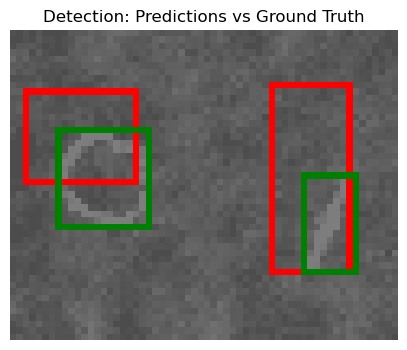

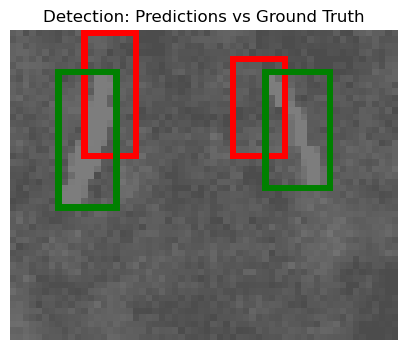

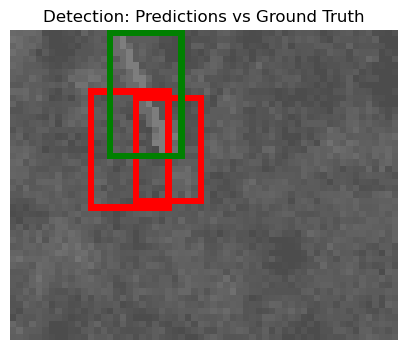

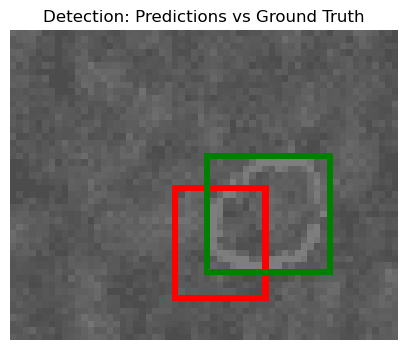

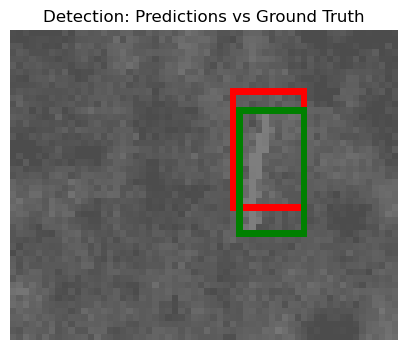

In [26]:
print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best combined performance: {best_score:.5f}")

for i in range(5):
    visualize_predictions_detection(best_model, data_val[i][0], data_val[i][1], preprocessor=preprocessor, mean=mean, std=std, detection_threshold=0.5)

### Tuning the best model

In [ ]:

def model_tuning(best_model):
    """
    Finding the hyperparameters that give the best model
    """
    # Define the hyperparameters
    learning_rates = [0.001, 0.0005, 0.0001]
    weight_decays = [0, 0.001, 0.01]
    #momentum = [0.9, 0.99]

    # Hyperparameters to add???
    # batch size
    # optimizer
    # momentum 
    # IoU threshold

    # getting the best model from the selection pipeline
    best_model_arch = best_model.__class__

    # Hyperparameter Tuning for the best architecture

    best_model_h = None
    best_score = 0
    best_hyperparams = {}

    # store for plotting
    best_loss = None
    best_accuracy = None
    best_iou = None
    best_performance = None

    for lr, wd in itertools.product(learning_rates, weight_decays):
        print(f"Tuning {best_model_arch.__name__} with lr={lr}, weight_decay={wd}:")
        
        # Instantiate a new model for each hyperparameter combination
        model = best_model_arch()
        #model = model_class().to(device=device, dtype=torch.double)

        # Create an optimizer with current hyperparameters
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        
        # Train the model on the training data
        losses_train, performance_train, accuracy_train, iou_train = train(
            n_epochs=5,
            optimizer=optimizer,
            model=model,
            loss_func=loss_func,
            train_loader=train_loader
        )
        
        # Evaluate the model on the validation data
        model.eval()
        performance, accuracy, IoU = overall_performance(model, val_loader, preprocessor=None)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Iou: {IoU}")
        print(f"Combined performance: {performance:.4f}\n")
        
        # Update the best model if performance improves
        if performance > best_score:
            best_score = performance
            best_model_h = model
            best_hyperparams = {
                'model': best_model_arch.__name__,
                'lr': lr,
                'weight_decay': wd
            }
            # Store loss, accuracy, iou, performance of the best performing model for plotting
            best_loss = losses_train
            best_accuracy = accuracy_train
            best_iou = iou_train
            best_performance = performance_train

    return best_model_h, best_score, best_hyperparams, best_loss, best_accuracy, best_iou, best_performance

best_model_h, best_score, best_hyperparams, loss, acc, iou, perf = model_tuning(best_model)


Tuning SimpleResNet with lr=0.001, weight_decay=0:
11:08:33.925090  |  Epoch 1  |  Training loss 0.23767  |  Accuracy 0.98841  | IoU 0.40528  |  Overall 0.69685
Accuracy: 0.9877
Iou: 0.40651947259902954
Combined performance: 0.6971

Tuning SimpleResNet with lr=0.001, weight_decay=0.001:
11:11:45.853936  |  Epoch 1  |  Training loss 0.25373  |  Accuracy 0.98646  | IoU 0.40946  |  Overall 0.69796
Accuracy: 0.9869
Iou: 0.4097740054130554
Combined performance: 0.6983

Tuning SimpleResNet with lr=0.0005, weight_decay=0:
11:15:10.197083  |  Epoch 1  |  Training loss 0.33215  |  Accuracy 0.98158  | IoU 0.38248  |  Overall 0.68203
Accuracy: 0.9813
Iou: 0.384147047996521
Combined performance: 0.6827

Tuning SimpleResNet with lr=0.0005, weight_decay=0.001:
11:18:31.426841  |  Epoch 1  |  Training loss 0.36953  |  Accuracy 0.97464  | IoU 0.31927  |  Overall 0.64695
Accuracy: 0.9732
Iou: 0.32016852498054504
Combined performance: 0.6467



### Performance and visualization of best model after tuning

Best hyperparameters: {'model': 'SimpleResNet', 'lr': 0.001, 'weight_decay': 0.001}
Best overall performance on validation set: 0.69833


/var/folders/z4/lpyly_x97q9bvdf2n62j780h0000gn/T/ipykernel_39668/562855466.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean, device=image.device).view(-1, 1, 1)
/var/folders/z4/lpyly_x97q9bvdf2n62j780h0000gn/T/ipykernel_39668/562855466.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std, device=image.device).view(-1, 1, 1)


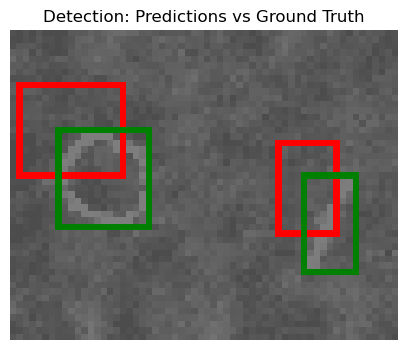

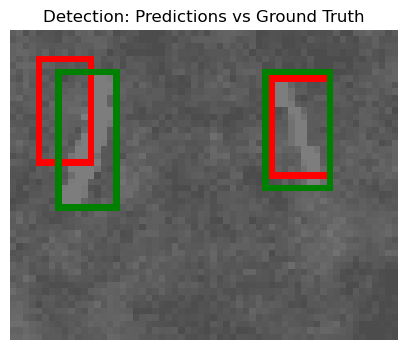

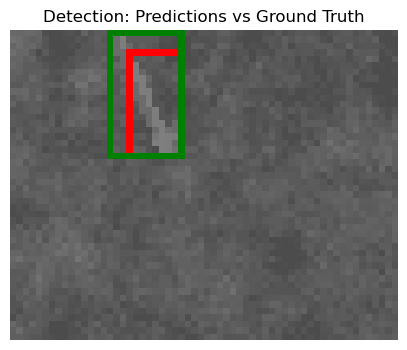

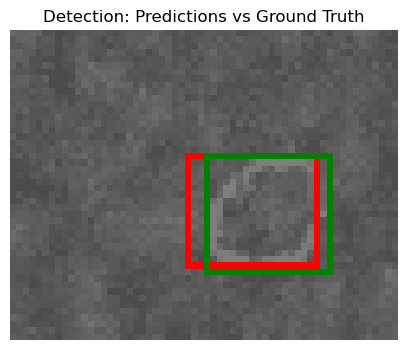

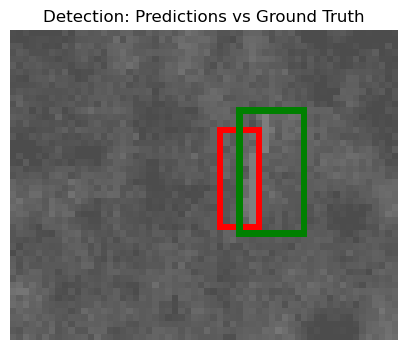

In [23]:
print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best overall performance on validation set: {best_score:.5f}")

for i in range(5):
    visualize_predictions_detection(best_model_h, data_val[i][0], data_val[i][1], preprocessor=preprocessor, mean=mean, std=std, detection_threshold=0.5)

### Plot of loss, accuracy, iou and overall performance for best performing model

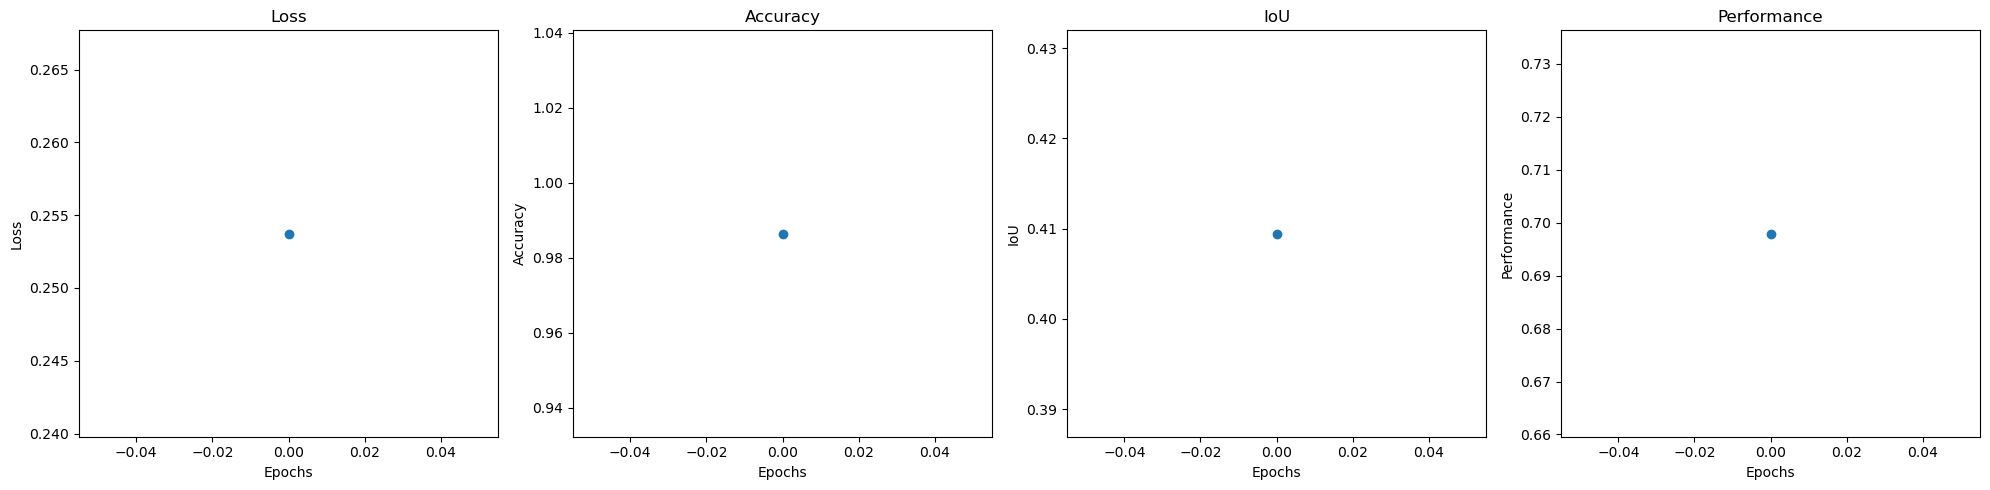

In [24]:
def plot(loss, accuracy, iou, performance):
    """
    Plots four metrics (loss, accuracy, IoU, performance) in a row.
    The x-axis represents the length of each respective list.
    """
    metrics = [("Loss", loss), ("Accuracy", accuracy), ("IoU", iou), ("Performance", performance)]
    
    plt.figure(figsize=(20, 5))  # Set figure size for a row of 4 plots
    
    for i, (title, data) in enumerate(metrics):
        plt.subplot(1, 4, i + 1)  # Create a 1x4 grid of subplots
        plt.plot(range(len(data)), data, marker='o', linestyle='-')  # Plot the data
        plt.xlabel("Epochs")  # Label x-axis
        plt.ylabel(title)  # Label y-axis
        plt.title(title)  # Set title

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plots


plot(loss, acc, iou, perf) # verdier fra model tuning

### Evaluating best model on test set

In [ ]:
# Final Testing on the test set

test_overall_performance, test_accuracy, test_iou = overall_performance(best_model_h, test_loader, preprocessor=None)
print(f"Test overall performance: {test_overall_performance:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test IoU: {test_iou:.4f}")